# Import the Required Libraries

# Parkinson's Disease Progression Prediction with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the AMP®-Parkinson's Disease Progression Prediction dataset made available for this competition. The model must predict MDS-UPDR scores, which measure progression in patients with Parkinson's disease.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

This notebook will also show how to do some pre-processing of the data to make it easier for an ML models to learn from it.

You'll also learn how to implement and use the evaluation metric used on this competition: SMAPE.

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os
import math
import time
from tqdm import tqdm
import pylab
from scipy.stats import shapiro
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, LSTM, MaxPooling1D, TimeDistributed, RepeatVector, Flatten, GRU, RNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
#from torcheval.metrics import R2Score

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Dataset

First, let us load the dataset using Pandas.

In [ ]:
# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

We will now examine each of these DataFrames in detail.

UPDRS is a rating instrument used to measure the the severity and progression of Parkinson’s disease in patients.
When a patient visits the clinic, the clinic will record how the patient scored on 4 parts of  UPDRS test. This data can be found in `train_clinical`. The ratings for the the first 4 segments of UPDRS are available as `updrs_1`, `updrs_2`, `updrs_3` and `updrs_4` in `train_clinical`.
Our goal is to train a model to predict these UPDRS ratings.

Let us examine the shape of `train_clinical` DataFrame.

In [ ]:
print('clinical dataset shape:  ', train_clinical.shape)

clinical dataset shape:   (2615, 8)


The `train_clinical` data is composed of ***8* columns** and ***2615* entries**.  We can see all 8 dimensions of our dataset by printing out the first 5 entries using the following code:

In [ ]:
# Display the first 5 examples
train_clinical.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [ ]:
train_clinical.describe()

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
count,2615.000000,2615.000000,2614.000000,2613.00000,2590.000000,1577.000000
mean,32651.743786,31.190822,7.110559,6.74359,19.421236,1.861763
std,18535.758700,25.199053,5.525955,6.32323,15.000289,3.022112
min,55.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,16574.000000,10.500000,3.000000,1.00000,6.000000,0.000000
50%,29417.000000,24.000000,6.000000,5.00000,19.000000,0.000000
75%,50611.000000,48.000000,10.000000,10.00000,29.000000,3.000000
max,65043.000000,108.000000,33.000000,40.00000,86.000000,20.000000


We notice moderate correlation between updrs_2 and updrs_3 (0.735106) and between updrs_1 and updrs_2 (0.661802)

In [ ]:
# Number of unique patients
len(train_clinical['patient_id'].unique())

248

In [ ]:
# Display visit month intervals
train_clinical['visit_month'].unique()

array([  0,   3,   6,   9,  12,  18,  24,  30,  36,  42,  48,  54,  60,
        72,  84,  96, 108])

In [ ]:
# Number of unique visit month intervals
len(train_clinical['visit_month'].unique())

17

In [ ]:
# Group by patient_id and calculate the average number of unique visit_month per patient
avg_visits_per_patient = train_clinical.groupby('patient_id')['visit_month'].nunique().mean()
print(f"The average number of recorded visits per patient is {avg_visits_per_patient}")

The average number of recorded visits per patient is 10.544354838709678


In [ ]:
# Number of unique updrs_1
len(train_clinical['updrs_1'].unique())

33

<AxesSubplot: >

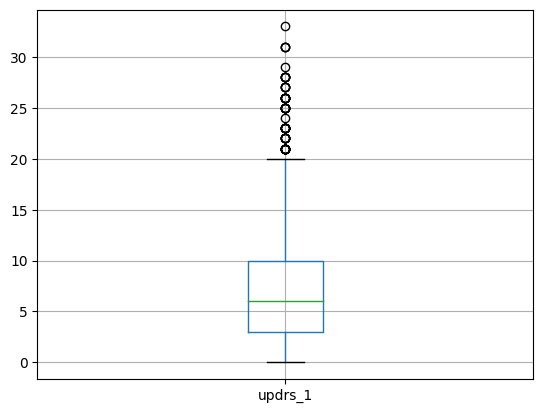

In [ ]:
train_clinical[['updrs_1']].boxplot()

In [ ]:
# Number of unique updrs_2
len(train_clinical['updrs_2'].unique())

37

<AxesSubplot: >

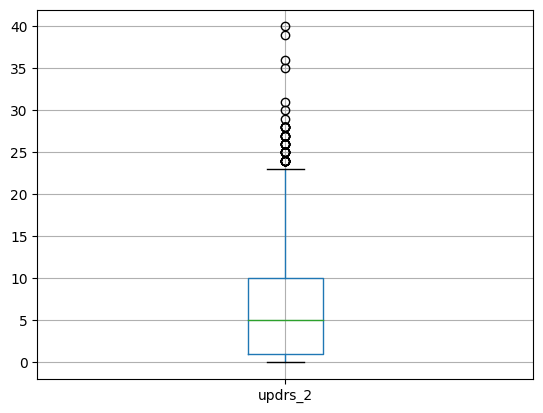

In [ ]:
train_clinical[['updrs_2']].boxplot()

In [ ]:
# Number of unique updrs_3
len(train_clinical['updrs_3'].unique())

73

<AxesSubplot: >

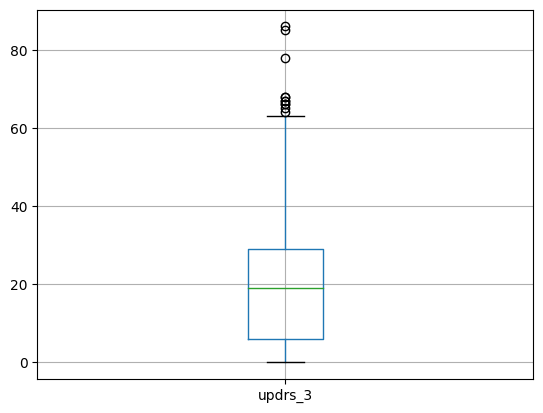

In [ ]:
train_clinical[['updrs_3']].boxplot()

In [ ]:
# Number of unique updrs_4
len(train_clinical['updrs_4'].unique())

20

<AxesSubplot: >

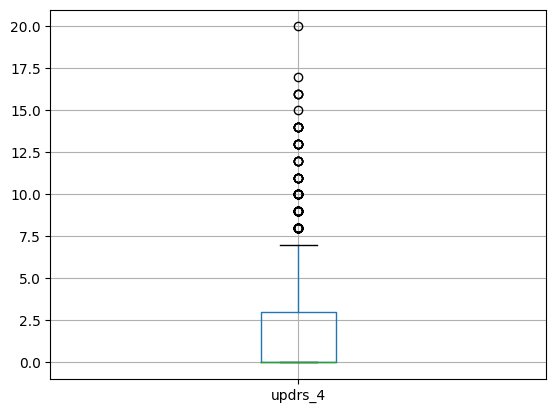

In [ ]:
train_clinical[['updrs_4']].boxplot()

In [ ]:
# Show correlations among UPDRS scores
train_clinical.corr()

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
patient_id,1.000000,-0.019781,0.048258,0.037762,0.047173,-0.009203
visit_month,-0.019781,1.000000,0.121625,0.132308,0.135300,0.138013
updrs_1,0.048258,0.121625,1.000000,0.661802,0.434569,0.432620
updrs_2,0.037762,0.132308,0.661802,1.000000,0.735106,0.383866
updrs_3,0.047173,0.135300,0.434569,0.735106,1.000000,0.221593
updrs_4,-0.009203,0.138013,0.432620,0.383866,0.221593,1.000000


The clinic will also record the patient's **NPX**(Normalized Protein eXpression) value for all the proteins relevant to Parkinson's disease during each visit. **NPX** is nothing but the value representing the protein concentration in shells. This data is available in the `train_proteins` DataFrame.

Let us examine the shape of `train_proteins` DataFrame.

In [ ]:
print('proteins dataset shape:  ', train_proteins.shape)

proteins dataset shape:   (232741, 5)


The `train_proteins` data is composed of ***5* columns** and ***232741* entries**. We can see all 5 dimensions of our dataset by printing out the first 5 entries using the following code:

In [ ]:
# Display the first 5 examples
train_proteins.head(5)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [ ]:
train_proteins.describe()

,visit_month,patient_id,NPX
count,232741.000000,232741.000000,2.327410e+05
mean,26.099205,32593.881873,2.712077e+06
std,22.874719,18608.479506,2.224155e+07
min,0.000000,55.000000,8.460820e+01
25%,6.000000,16566.000000,2.946440e+04
50%,24.000000,29313.000000,1.135560e+05
75%,48.000000,49995.000000,5.638940e+05
max,108.000000,65043.000000,6.138510e+08


In [ ]:
# Number of unique proteins in dataframe
len(train_proteins['UniProt'].unique())

227

<AxesSubplot: >

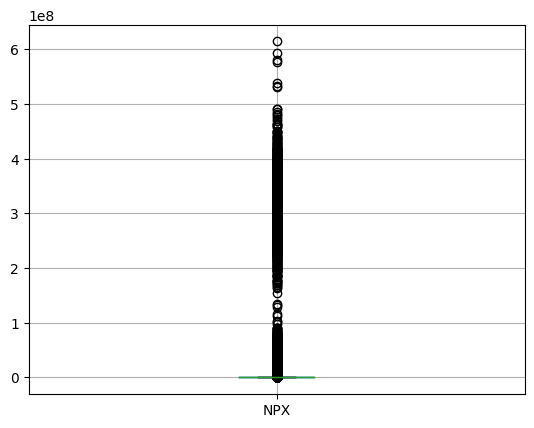

In [ ]:
train_proteins[['NPX']].boxplot()

In [ ]:
# Number of unique patients in dataframe
len(train_proteins['patient_id'].unique())

248

In [ ]:
# Show number of recorded visits per patient. We are trying to figure out how often UniProt values are taken
train_proteins.groupby("patient_id")['visit_month'].nunique().describe()

count    248.000000
mean       4.487903
std        1.542861
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: visit_month, dtype: float64

In [ ]:
# Let's find the patients with the max number of visits in this dataframe so we can explore them later
train_proteins.groupby("patient_id")['visit_month'].nunique()[train_proteins.groupby("patient_id")['visit_month'].nunique() == 9]

patient_id
18183    9
20404    9
23391    9
26210    9
58648    9
62723    9
Name: visit_month, dtype: int64

Proteins are long molecules made up of multiple peptides. The clinic will record the **Peptide Abundance** of each peptide in proteins relevant to Parkinson's disease. It shows the peptide concentration, similar to NPX for proteins.  This data can be found in the `train_peptides` DataFrame.

Let us examine the shape of the `train_peptides` DataFrame.

In [ ]:
print('peptides dataset shape:  ', train_peptides.shape)

peptides dataset shape:   (981834, 6)


The **train_peptides** data is composed of ***6* columns** and ***981834* entries**. We can see all 6 dimensions of our dataset by printing out the first 5 entries using the following code:

In [ ]:
# Display the first 5 examples
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [ ]:
train_peptides.describe()

,visit_month,patient_id,PeptideAbundance
count,981834.000000,981834.000000,9.818340e+05
mean,26.105061,32603.465361,6.428902e+05
std,22.913897,18605.934422,3.377989e+06
min,0.000000,55.000000,1.099850e+01
25%,6.000000,16566.000000,2.817425e+04
50%,24.000000,29313.000000,7.430830e+04
75%,48.000000,49995.000000,2.213388e+05
max,108.000000,65043.000000,1.787520e+08


In [ ]:
# Number of unique proteins in dataframe
train_peptides['UniProt'].nunique()

227

In [ ]:
# Number of unique peptides in dataframe
train_peptides['Peptide'].nunique()

968

In [ ]:
# Number of unique patients in dataframe
train_peptides['patient_id'].nunique()

248

In [ ]:
# Number of unique peptides per patient
unique_peptides_per_patient = train_peptides.groupby('patient_id')['Peptide'].nunique().describe()
unique_peptides_per_patient

count    248.000000
mean     941.544355
std       27.584065
min      726.000000
25%      937.000000
50%      949.000000
75%      956.000000
max      965.000000
Name: Peptide, dtype: float64

# Plotting clinical data

We will pick a random `patient_id` and plot the target label values(`updrs_1`, `updrs_2`, `updrs_3`, `updrs_4`) of the patient against each month(`visit_month`).

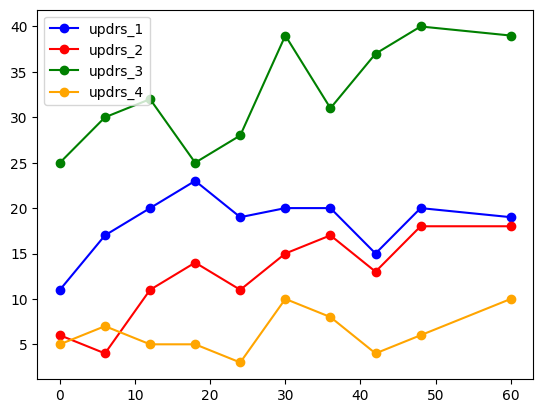

In [ ]:
# Fetch data for patient with id 1517
plot_df = train_clinical[train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
plt.show()

# Plotting protein data


We will pick a random `patient_id` and plot the first 40 Protein entries(`UniProt`) of the patient and their NPX value against patient's visit month(`visit_month`).

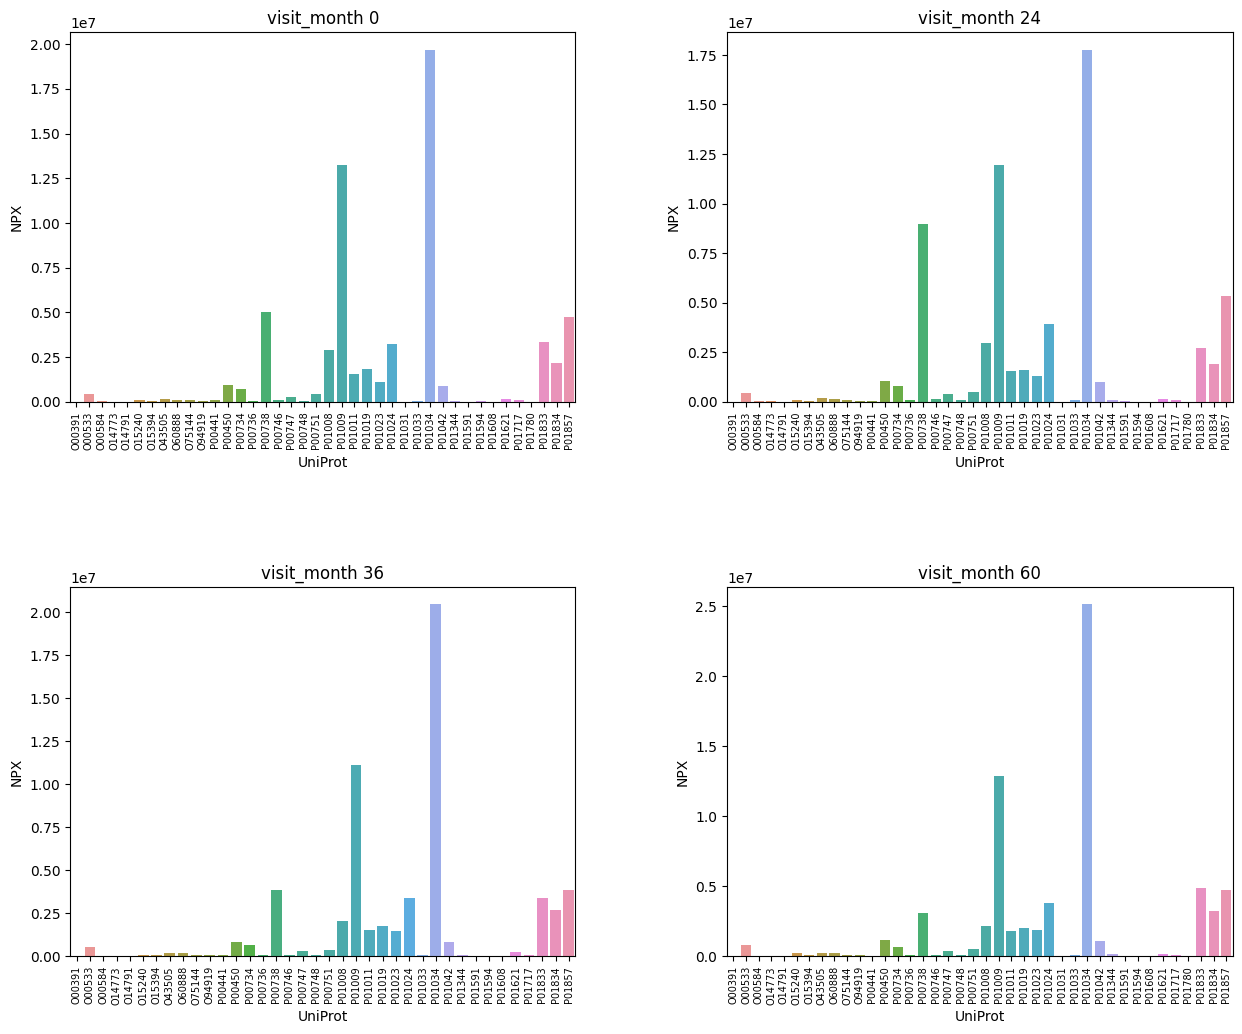

In [ ]:
pro_plot_df = train_proteins[train_proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len/2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    #bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))
plt.show()

# Prepare the dataset

We have to predict the ratings for the the first 4 segments of UPDRS `updrs_1`, `updrs_2`, `updrs_3` and `updrs_4` that is likely to be recorded by the clinic during a patient visit. Hence these are our labels.

We will now prepare the dataset for training models to predict the 4 labels.

To predict the target labels(`updrs_1`, `updrs_2`, `updrs_3`, `updrs_4`) for a given visit, we will use the recorded protein and peptide data of the patient during that visit.

First we will group the rows in `train_proteins` data by visit ids (`visit id`) and protein ids (`UniProt`). Then we will replace the`NPX` values of each row in a group with the mean of the `NPX` values of all rows in that group.

Similarly we will group the rows in `train_peptides` data by their visit ids(`visit_id`) and peptide ids(`Peptide`). Then we will replace the `PeptideAbundance` values of each row in a group with the mean of the `PeptideAbundance` values of all rows in that group.

Following figure shows the working of Pandas groupby function.

Now we will spread the rows of the grouped datasets into columns. For this we will use the Pandas pivot function.

Below is a simple explanation for how the pivoting works.

The Protein dataset is pivoted such that unique values of `visit_id` become the indices and the values of `UniProt1` in the dataset become columns. For each visit(row), the `NPX` values corresponding to the different`UniProt1` values recorded for that visit are captured in the columns.

The Peptipe dataset is pivoted such that unique values of `visit_id` become the indices and the values of `Peptide` in the dataset become columns. For each visit(row), the `PeptideAbundance` values corresponding to the different`Peptide` values recorded for that visit are captured in the columns.

In [ ]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()

    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')

    return pro_pep_df

In [ ]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

# Basic exploration of the prepared dataset

In [ ]:
pro_pep_df.shape

(1113, 1196)

Our feature engineered dataset is composed of 1196 columns and 1113 entries.

Let us print out the first 5 entries using the following code:

In [ ]:
# Display the first 5 examples
pro_pep_df.head(5)

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [ ]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


Now let us write a function to split the dataset into train and test datasets. This will be used in the training loop.

In [ ]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

Before training the model, let us write a function to calculate the scoring metric of the competition.

# sMAPE

The scoring metric for this competition is sMAPE(symmetric Mean Absolute Percentage Error). In MAPE(Mean Absolute Percentage Error) we calculate the sum of absolute value of the forecast errors, divided by the actual values for each period

Since TensorFlow Datasets doesn't have a bultin function to calculate sMAPE metric yet, we will write a custom function to calculate sMAPE.

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Training

We will train a model each to predict the first 4 segments of the UPDRS, `updrs_1`, `updrs_2`, `updrs_3` and `updrs_4`. Thus we we will be training 4 models, one for each label.

We need to provide a few data structures to our training loop to store the trained models, sMAPE scores and mse scores for the trained models.

We will create these using the following code:

In [ ]:
# Create an empty dictionary to store the models trained for each label.
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

Next, we will create a feature list with names of the columns we will use for training the model. We will avoid the column `visit_id` and add column the `visit_month`

In [ ]:
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")

Now let us train the models.

In [ ]:
def cnn_lstm():
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=14, kernel_size=1, activation="relu",
                                     input_shape=(X.shape[1], X.shape[2]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(21, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(14, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(7))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

869 examples in training, 199 examples in testing.
Epoch 1/400
55/55 [==============================] - 15s 36ms/step - loss: 67.2672 - mse: 67.2672 - mae: 6.4040 - val_loss: 88.6384 - val_mse: 88.6384 - val_mae: 7.1696
Epoch 2/400
55/55 [==============================] - 0s 9ms/step - loss: 66.0779 - mse: 66.0779 - mae: 6.3226 - val_loss: 86.8367 - val_mse: 86.8367 - val_mae: 7.0492
Epoch 3/400
55/55 [==============================] - 0s 9ms/step - loss: 63.8163 - mse: 63.8163 - mae: 6.1616 - val_loss: 82.9326 - val_mse: 82.9326 - val_mae: 6.7806
Epoch 4/400
55/55 [==============================] - 1s 9ms/step - loss: 58.9870 - mse: 58.9870 - mae: 5.8131 - val_loss: 75.3950 - val_mse: 75.3950 - val_mae: 6.2444
Epoch 5/400
55/55 [==============================] - 1s 9ms/step - loss: 52.2393 - mse: 52.2393 - mae: 5.3344 - val_loss: 66.5394 - val_mse: 66.5394 - val_mae: 5.7205
Epoch 6/400
55/55 [==============================] - 1s 10ms/step - loss: 45.3106 - mse: 45.3106 - mae: 4.9140 -

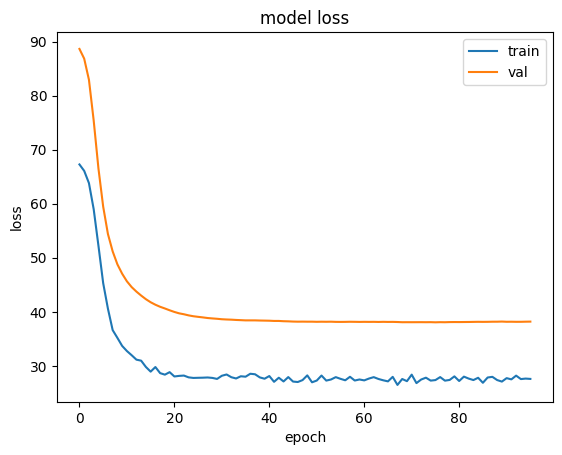

875 examples in training, 193 examples in testing.
Epoch 1/400
55/55 [==============================] - 8s 32ms/step - loss: 67.9880 - mse: 67.9880 - mae: 5.7841 - val_loss: 72.7268 - val_mse: 72.7268 - val_mae: 5.9859
Epoch 2/400
55/55 [==============================] - 0s 9ms/step - loss: 66.9491 - mse: 66.9491 - mae: 5.7361 - val_loss: 71.2244 - val_mse: 71.2244 - val_mae: 5.9224
Epoch 3/400
55/55 [==============================] - 1s 9ms/step - loss: 64.7802 - mse: 64.7802 - mae: 5.6403 - val_loss: 67.9551 - val_mse: 67.9551 - val_mae: 5.7792
Epoch 4/400
55/55 [==============================] - 0s 9ms/step - loss: 60.6140 - mse: 60.6140 - mae: 5.4462 - val_loss: 62.4746 - val_mse: 62.4746 - val_mae: 5.5214
Epoch 5/400
55/55 [==============================] - 0s 9ms/step - loss: 55.3613 - mse: 55.3613 - mae: 5.1841 - val_loss: 56.9308 - val_mse: 56.9308 - val_mae: 5.2909
Epoch 6/400
55/55 [==============================] - 0s 9ms/step - loss: 50.6579 - mse: 50.6579 - mae: 4.9737 - v

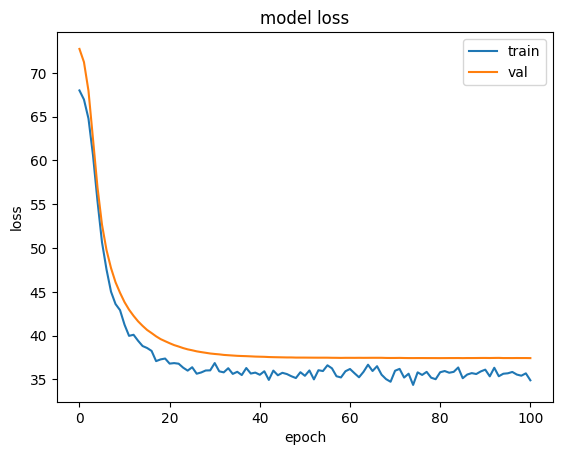

857 examples in training, 201 examples in testing.
Epoch 1/400
54/54 [==============================] - 8s 29ms/step - loss: 500.8475 - mse: 500.8475 - mae: 16.9337 - val_loss: 621.4088 - val_mse: 621.4088 - val_mae: 18.8262
Epoch 2/400
54/54 [==============================] - 0s 9ms/step - loss: 495.7369 - mse: 495.7369 - mae: 16.8365 - val_loss: 613.1887 - val_mse: 613.1887 - val_mae: 18.6769
Epoch 3/400
54/54 [==============================] - 0s 9ms/step - loss: 485.9793 - mse: 485.9793 - mae: 16.6557 - val_loss: 598.3740 - val_mse: 598.3740 - val_mae: 18.4032
Epoch 4/400
54/54 [==============================] - 0s 9ms/step - loss: 470.4793 - mse: 470.4793 - mae: 16.3544 - val_loss: 578.1248 - val_mse: 578.1248 - val_mae: 18.0447
Epoch 5/400
54/54 [==============================] - 0s 9ms/step - loss: 451.2322 - mse: 451.2322 - mae: 16.0018 - val_loss: 557.0120 - val_mse: 557.0120 - val_mae: 17.6796
Epoch 6/400
54/54 [==============================] - 0s 9ms/step - loss: 434.1380 -

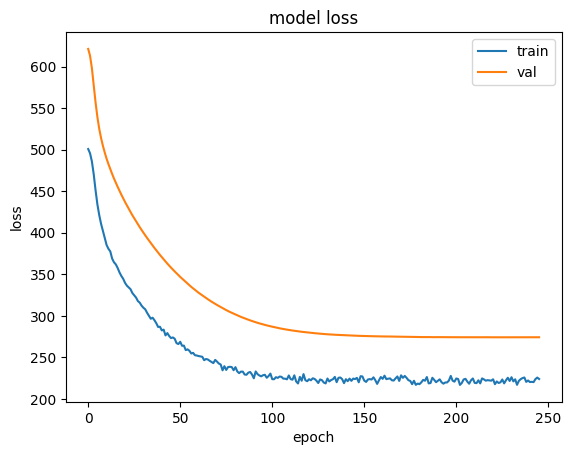

440 examples in training, 129 examples in testing.
Epoch 1/400
28/28 [==============================] - 7s 52ms/step - loss: 12.7111 - mse: 12.7111 - mae: 1.9087 - val_loss: 13.6117 - val_mse: 13.6117 - val_mae: 1.9240
Epoch 2/400
28/28 [==============================] - 0s 10ms/step - loss: 12.5310 - mse: 12.5310 - mae: 1.9140 - val_loss: 13.4223 - val_mse: 13.4223 - val_mae: 1.9357
Epoch 3/400
28/28 [==============================] - 0s 10ms/step - loss: 12.3311 - mse: 12.3311 - mae: 1.9248 - val_loss: 13.1800 - val_mse: 13.1800 - val_mae: 1.9513
Epoch 4/400
28/28 [==============================] - 0s 10ms/step - loss: 12.0448 - mse: 12.0448 - mae: 1.9393 - val_loss: 12.8779 - val_mse: 12.8779 - val_mae: 1.9715
Epoch 5/400
28/28 [==============================] - 0s 10ms/step - loss: 11.7082 - mse: 11.7082 - mae: 1.9617 - val_loss: 12.4574 - val_mse: 12.4574 - val_mae: 2.0017
Epoch 6/400
28/28 [==============================] - 0s 11ms/step - loss: 11.2223 - mse: 11.2223 - mae: 1.985

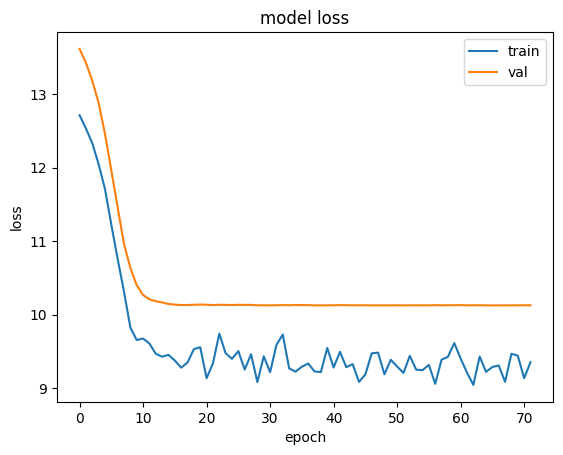

In [ ]:
# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Store evaluation metrics
MAE = []

# Loop through each label
for label in target:

    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical`
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(train_clinical[['visit_id', 'patient_id', 'visit_month', label]], on = ['visit_id'], how = 'left')

    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])

    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)

    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(dataset_df[feature_list])
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_df.iloc[:,:-1])
    X_valid = scaler.transform(valid_df.iloc[:,:-1])

    X = []
    Y = []
    T = 2

    for i in range(T, X_train.shape[0]):
      x = X_train[i-T:i,:]
      X.append(x)
      y = train_df.iloc[i,-1]
      Y.append(y)

    X,Y=np.array(X),np.array(Y)
    subseq = 1
    X = X.reshape(X.shape[0],subseq,X.shape[1],X.shape[2])

    X_val = []
    Y_val = []
    T = 2

    for i in range(T, X_valid.shape[0]):
      x = X_valid[i-T:i,:]
      X_val.append(x)
      y = valid_df.iloc[i,-1]
      Y_val.append(y)

    X_val,Y_val=np.array(X_val),np.array(Y_val)
    subseq = 1
    X_val = X_val.reshape(X_val.shape[0],subseq,X_val.shape[1],X_val.shape[2])


    model = cnn_lstm()
    opt = keras.optimizers.Adam(learning_rate=0.0005)
    early_stop = EarlyStopping(monitor='val_loss', patience=20)
    model.compile(optimizer=opt, loss='mse', metrics=['mse','mae'])
    epochs = 400
    batch = 16
    history = model.fit(X, Y, epochs=epochs, batch_size=batch, validation_data=(X_val, Y_val), callbacks=[early_stop], verbose=1).history

    # Store the model
    model_dict[label] = model

    mse_dict[label] = model.evaluate(X,Y)[0]
    MAE.append(model.evaluate(X,Y)[2])
    print(model.evaluate(X, Y))

    y_pred = model.predict(X_val)
    YY = np.reshape(Y_val,(y_pred.shape[0],1))
    smape_dict[label] = smape(YY, y_pred)
    print(smape(YY, y_pred))

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

# Inspect the Mean Squared Error(MSE) scores of the models.

In [ ]:
for name, value in mse_dict.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict.values())/4)

label updrs_1: mse 26.3371
label updrs_2: mse 34.7277
label updrs_3: mse 215.0964
label updrs_4: mse 9.1714

Average mse 71.33313727378845


# Inspect the sMAPE scores of the models

In [ ]:
for name, value in smape_dict.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict.values())/4)

label updrs_1: sMAPE 70.2901
label updrs_2: sMAPE 97.8760
label updrs_3: sMAPE 87.0864
label updrs_4: sMAPE 152.8375

Average sMAPE 102.02250622165893


# Inspect the MAE scores of the models

In [ ]:
MAE

[4.016890048980713, 4.699072360992432, 12.273669242858887, 2.350952625274658]

In [ ]:
np.mean(MAE)

5.835146069526672

# Visualize the model

One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300.

Let us pick one model from `model_dict` and select a tree to display below.

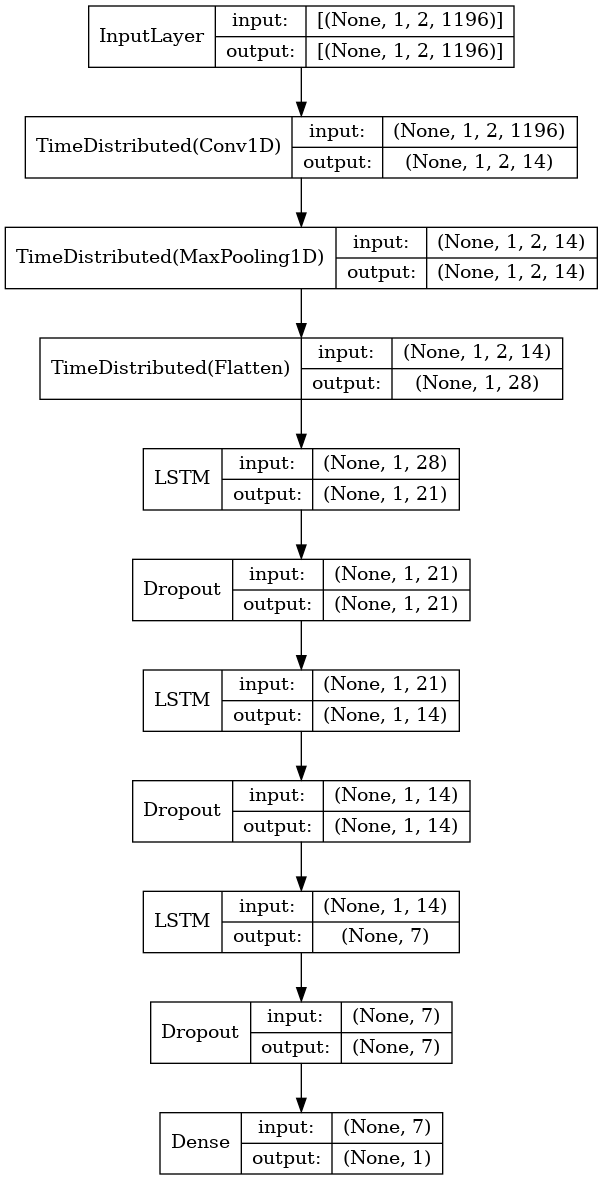

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=False)

# Submission

In [ ]:
import amp_pd_peptide_310
env = amp_pd_peptide_310.make_env()   # initialize the environment

In [ ]:
iter_test = env.iter_test()

In [ ]:
def get_predictions(test_df, model_dict):
    # Target labels
    target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
    temp = test_df[FEATURES].copy()

    # Filter out all the 0 value columns before predicting
    mask = temp.sum(axis=1) != 0
    new_test_df = temp.loc[mask]

    # Add extra columns with 0 values if necessary
    if new_test_df.shape[1] < 1196:
        extra_cols = pd.DataFrame(0, index=new_test_df.index, columns=range(new_test_df.shape[1], 1196))
        new_test_df = pd.concat([new_test_df, extra_cols], axis=1)

    T = 1
    subseq = 1

    for u in target:
        X = []
        for i in range(new_test_df.shape[0]-T+1):
            x = new_test_df.iloc[i:i+T,:]
            X.append(x)

        X = np.array(X)
        X = X.reshape(X.shape[0], subseq, X.shape[1], X.shape[2])
        test_df['result_' + str(u)] = 0
        if u != 'updrs_4':
            print(model_dict[u])
            test_df.loc[mask, 'result_' + str(u)] = model_dict[u].predict(X)

    # Format for final submission
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:
            temp = test_df[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]
            result = result.append(temp)

    result = result.drop_duplicates(subset=['prediction_id', 'rating'])
    return result

In [ ]:
# Reference: https://www.kaggle.com/code/xarispanagiotopoulos/linearregression-xgb/notebook

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    pro_pep_df = prepare_dataset(test_proteins, test_peptides)


    test_proteins = test_proteins.pivot(index=['visit_id', 'visit_month', 'patient_id'],
              columns='UniProt', values='NPX').reset_index().rename_axis(None, axis=1).drop(columns=['visit_month', 'patient_id'])
    merged_df = test.merge(test_proteins, how='left', on='visit_id')

    test_df = test.merge(pro_pep_df, how='left', on='visit_id')

    # Add all the missing columns from FEATURES list and set the values as 0
    for col in FEATURES:
        if col not in test_df.columns:
            test_df[col] = 0

    test_df = test_df[['visit_id', 'patient_id'] + FEATURES]
    # assume you have a DataFrame called `df` with multiple columns

    result = get_predictions(test_df, model_dict)
    print(result)

    env.predict(result)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 2s 2s/step
                    prediction_id     rating
0    3342_0_updrs_1_plus_0_months   0.000000
4   50423_0_updrs_1_plus_0_months   5.500661
0    3342_0_updrs_2_plus_0_months   0.000000
4   50423_0_updrs_2_plus_0_months   5.516562
0    3342_0_updrs_3_plus_0_months   0.000000
4   50423_0_updrs_3_plus_0_months  15.639747
0    3342_0_updrs_4_plus_0_months   0.000000
4   50423_0_updrs_4_plus_0_months   0.000000
0    3342_0_updrs_1_plus_6_months   0.000000
4   50423_0_updrs_1_plus_6_months   5.500661
0    3342_0_updrs_2_plus_6_months   0.000000
4   50423_0_updrs_2_plus_6_months   5.516562
0    3342_0_updrs_3_plus_6_months   0.000000
4   50423_0_updrs_3_plus_6_months  15.639747
0    3342_0_updrs_4_plus_6_months   0.000000
4   50423_0_updrs_4_plus_6_months   0.000000
0   3342_0_updrs_1_plus_12_months   0.000000
4  50423_0_updr